In [72]:
import numpy as np
import pandas as pd
import pycountry
from datetime import datetime
import os

import requests
from bs4 import BeautifulSoup
import csv
import re

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

%matplotlib inline





In [13]:
#collect list of Top100 airlines (source: https://www.flightsfrom.com/top-100-airlines)


headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) /Chrome/88.0.4324.104 Safari/537.36'}


tmplist=[]

counter=0
response=requests.get(f'https://www.flightsfrom.com/top-100-airlines',headers=headers)
soup=BeautifulSoup(response.text, 'html.parser')

tmplist=soup.find_all('span', attrs = {'class': 'hometoplist-first'})

top100_airlines=[]

for tmp in tmplist:
    top100_airlines.append(tmp.get_text().strip())
    
    
    

In [4]:
#iterate through all flight data files and collect grouped operator/owner data
import pandas as pd

import os

operator_data=pd.read_csv('aircraftDatabase-2021-07.csv')
operator_data.operator.fillna(operator_data.owner, inplace=True)
operator_data_filtered=operator_data.loc[:,['icao24','operator']]

csv_data=pd.read_csv('flightlist_20210601_20210630.csv')
csv_data2=csv_data[['callsign','icao24','origin','destination','firstseen','lastseen']]
flight_data_consolidated=csv_data2.merge(operator_data_filtered, on='icao24', how='left')
flight_data_grouped_total=flight_data_consolidated.groupby('operator').agg('count').sort_values('callsign', ascending=False)


counter=1
directory = r'/Users/moritz/Desktop/covid-vaccination-flight-analysis/flight_data'
for entry in os.scandir(directory):
    if entry.path.endswith(".csv") and entry.is_file():
        print (counter)
        csv_data=pd.read_csv(entry)
        csv_data2=csv_data[['callsign','icao24','origin','destination','firstseen','lastseen']]
        flight_data_consolidated=csv_data2.merge(operator_data_filtered, on='icao24', how='left')
        flight_data_grouped=flight_data_consolidated.groupby('operator').agg('count').sort_values('callsign', ascending=False)
        flight_data_grouped_total=pd.concat([flight_data_grouped_total,flight_data_grouped],axis=0, sort=False)
        print ('\n')
        print (entry)
        counter+=1

flight_data_grouped_total=flight_data_grouped_total.groupby('operator').agg('sum').sort_values('callsign', ascending=False)
flight_data_grouped_total.to_csv('grouped_operators.csv')        




1


<DirEntry 'flightlist_20200801_20200831.csv'>
2


<DirEntry 'flightlist_20191101_20191130.csv'>
3


<DirEntry 'flightlist_20190201_20190228.csv'>
4


<DirEntry 'flightlist_20191201_20191231.csv'>
5


<DirEntry 'flightlist_20190901_20190930.csv'>
6


<DirEntry 'flightlist_20210201_20210228.csv'>
7


<DirEntry 'flightlist_20201001_20201031.csv'>
8


<DirEntry 'flightlist_20190801_20190831.csv'>
9


<DirEntry 'flightlist_20201201_20201231.csv'>
10


<DirEntry 'flightlist_20201101_20201130.csv'>
11


<DirEntry 'flightlist_20200201_20200229.csv'>
12


<DirEntry 'flightlist_20200901_20200930.csv'>
13


<DirEntry 'flightlist_20191001_20191031.csv'>
14


<DirEntry 'flightlist_20190501_20190531.csv'>
15


<DirEntry 'flightlist_20190601_20190630.csv'>
16


<DirEntry 'flightlist_20190301_20190331.csv'>
17


<DirEntry 'flightlist_20200701_20200731.csv'>
18


<DirEntry 'flightlist_20200101_20200131.csv'>
19


<DirEntry 'flightlist_20200401_20200430.csv'>
20


<DirEntry 'flightlist_20210501_2021

/Users/moritz/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,




<DirEntry 'flightlist_20190101_20190131.csv'>
29


<DirEntry 'flightlist_20190701_20190731.csv'>


In [21]:
#Fuzzy match operator data with Top100 airline list

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

airline_mapping=pd.DataFrame(columns=['operator','airline_match','fuzzy_rank'])

for operator_ in list(flight_data_grouped_total.index):
    dict_={}
    for airline in top100_airlines:
        dict_[airline]=fuzz.ratio(operator_,airline)
    maximum_fuzzy_match=max(dict_, key=lambda key: dict_[key])
    maximum_fuzzy_value=max(dict_.values())
    airline_mapping.loc[len(airline_mapping.index)]=[operator_,maximum_fuzzy_match,maximum_fuzzy_value]


airline_mapping.to_csv('airline_mapping.csv')

#use fuzzy-matched data and manually adjust/ correct (overall, reduced # of relevant flights from #57297620 to 32051497)
airline_mapping_corrected=pd.read_csv('airline_mapping_manual.csv')


flight_data_grouped_corrected=flight_data_grouped_total.merge(airline_mapping_corrected, on='operator', how='left')

relevant_operators=flight_data_grouped_corrected[~flight_data_grouped_corrected['airline_match'].isnull()]['operator']


In [47]:
#concatenate all monthly flight data files into one long table
import pandas as pd

import os

flight_data=pd.read_csv('flightlist_20210601_20210630.csv')
flight_data_consolidated=flight_data.merge(operator_data_filtered, on='icao24', how='left')        
flight_data_consolidated=flight_data_consolidated[flight_data_consolidated['operator'].isin(relevant_operators)]
flight_data_consolidated2=flight_data_consolidated[['callsign','icao24','origin','destination','firstseen','lastseen']] 



counter=1
directory = r'/Users/moritz/Desktop/covid-vaccination-flight-analysis/flight_data'
for entry in os.scandir(directory):
    if entry.path.endswith(".csv") and entry.is_file():
        print (counter)
        flight_data=pd.read_csv(entry)
        flight_data_com=flight_data.merge(operator_data_filtered, on='icao24', how='left')        
        flight_data_com=flight_data_com[flight_data_com['operator'].isin(relevant_operators)]
        flight_data_com=flight_data_com[['callsign','icao24','origin','destination','firstseen','lastseen']]  
        
        
        flight_data_consolidated2=pd.concat([flight_data_consolidated2,flight_data_com],axis=0, sort=False)


        print ('\n')
        print (entry)
        counter+=1

flight_data_consolidated2.to_csv(f'flight_data_cons_1.csv')

  

1


<DirEntry 'flightlist_20200801_20200831.csv'>
2


<DirEntry 'flightlist_20191101_20191130.csv'>
3


<DirEntry 'flightlist_20190201_20190228.csv'>
4


<DirEntry 'flightlist_20191201_20191231.csv'>
5


<DirEntry 'flightlist_20190901_20190930.csv'>
6


<DirEntry 'flightlist_20210201_20210228.csv'>
7


<DirEntry 'flightlist_20201001_20201031.csv'>
8


<DirEntry 'flightlist_20190801_20190831.csv'>
9


<DirEntry 'flightlist_20201201_20201231.csv'>
10


<DirEntry 'flightlist_20201101_20201130.csv'>
11


<DirEntry 'flightlist_20200201_20200229.csv'>
12


<DirEntry 'flightlist_20200901_20200930.csv'>
13


<DirEntry 'flightlist_20191001_20191031.csv'>
14


<DirEntry 'flightlist_20190501_20190531.csv'>
15


<DirEntry 'flightlist_20190601_20190630.csv'>
16


<DirEntry 'flightlist_20190301_20190331.csv'>
17


<DirEntry 'flightlist_20200701_20200731.csv'>
18


<DirEntry 'flightlist_20200101_20200131.csv'>
19


<DirEntry 'flightlist_20200401_20200430.csv'>
20


<DirEntry 'flightlist_20210501_2021

/Users/moritz/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,




<DirEntry 'flightlist_20190101_20190131.csv'>
29


<DirEntry 'flightlist_20190701_20190731.csv'>


,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2
0,ANA106,NaN,867f82,NaN,NaN,KORD,KLAX,2019-06-30 00:03:35+00:00,2019-07-01 00:13:28+00:00,2019-07-01 00:00:00+00:00,41.979309,-87.824083,609.6,33.953018,-118.393324,76.20
1,KQA204,KQ204,04c147,5Y-CYA,B738,FAOR,VABB,2019-06-30 00:45:42+00:00,2019-07-01 00:42:47+00:00,2019-07-01 00:00:00+00:00,-26.109614,28.245638,1524.0,19.088745,72.869911,99.06
2,CES771,MU771,781602,NaN,NaN,YSSY,EHAM,2019-06-30 01:09:12+00:00,2019-07-01 04:09:59+00:00,2019-07-01 00:00:00+00:00,-33.956314,151.178601,0.0,52.316059,4.741402,NaN
3,CSN465,NaN,7805aa,B-2075,B77L,KLAX,EGSS,2019-06-30 01:43:14+00:00,2019-07-01 06:26:53+00:00,2019-07-01 00:00:00+00:00,33.935715,-118.421014,0.0,51.900392,0.257943,114.30
4,CHH7921,NaN,780ff1,B-7880,B789,NaN,EBMB,2019-06-30 01:53:25+00:00,2019-07-01 05:40:58+00:00,2019-07-01 00:00:00+00:00,29.960369,106.983984,3657.6,50.903412,4.542624,83.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898410,JIA5636,NaN,a67407,N515AE,CRJ7,NaN,NaN,2019-07-31 23:46:13+00:00,2019-07-31 23:56:49+00:00,2019-07-31 00:00:00+00:00,34.783972,-81.011868,4267.2,33.878857,-81.615028,3406.14
2898411,SVA1910,NaN,710500,NaN,NaN,NaN,OETH,2019-07-31 23:46:14+00:00,2019-07-31 23:59:20+00:00,2019-07-31 00:00:00+00:00,24.668610,45.408020,8534.4,25.215363,46.414337,2727.96
2898412,SJY250,NaN,8a06b3,PK-CRH,B738,NaN,NaN,2019-07-31 23:46:17+00:00,2019-07-31 23:59:20+00:00,2019-07-31 00:00:00+00:00,-6.237076,106.709041,2133.6,-6.574448,108.059987,9677.40
2898413,SKW3787,NaN,ab161b,N813SK,CRJ9,KGRR,NaN,2019-07-31 23:47:43+00:00,2019-07-31 23:58:59+00:00,2019-07-31 00:00:00+00:00,42.879456,-85.516173,0.0,42.852173,-84.292276,5135.88


In [3]:

#read flight data (total)
flight_data=pd.read_csv('flight_data_cons_1.csv')


#change date in flight data from string to datetime object
def datecheck(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S+00:00')

flight_data['firstseen_num']=flight_data['firstseen'].apply(datecheck)
flight_data['lastseen_num']=flight_data['lastseen'].apply(datecheck)
flight_data['date_num']=flight_data['lastseen_num'].apply(datetime.date)

#--------------------

#read airport mapping data mapping airport codes to countries. Map countries to 3 digit ISO codes
airport_mapping=pd.read_csv('airport-codes_csv.csv')

def country_mapping(x):
    try:
        y=pycountry.countries.get(alpha_2=x).alpha_3
    except:
        y=''
    return y

airport_mapping['iso_country_3dig']=airport_mapping['iso_country'].apply(country_mapping)

#--------------------
#Merge flight data and airport to country mapping

flight_data_country=flight_data.merge(airport_mapping, how='left', left_on='origin', right_on='ident')

flight_data_country=flight_data_country[['callsign','icao24','origin','destination','firstseen_num','lastseen_num','date_num','ident','name','continent','iso_country','iso_country_3dig']]

#--------------------
#read vaccination data over time per country
vaccination_data=pd.read_csv('owid-covid-data.csv')


#filter out irrelevant columns and lines, and add vaccination percentage column
filtered_vaccination_data=vaccination_data[['iso_code','location','date','people_fully_vaccinated_per_hundred','population']]
filtered_vaccination_data=filtered_vaccination_data.loc[filtered_vaccination_data['date']>'2020-12-15']

#add correctly formatted date column to vaccination dataset
def datecheck_vac(x):
    return datetime.strptime(x, '%Y-%m-%d').date()

filtered_vaccination_data['date_num']=filtered_vaccination_data['date'].apply(datecheck_vac)

#--------------------
#Merge vaccination data into flight data

flight_data_completed=flight_data_country.merge(filtered_vaccination_data, how='left', left_on=['iso_country_3dig','date_num'], right_on=['iso_code','date_num'])

flight_data_completed.to_csv('final_flight_table.csv')



,Unnamed: 0,callsign,icao24,origin,destination,firstseen,lastseen,firstseen_num,lastseen_num,date_num,...,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,iso_country_3dig
0,1,FDX5021,ac1e56,KOAK,RJBB,2021-05-31 01:34:38+00:00,2021-06-01 10:22:16+00:00,2021-05-31 01:34:38,2021-06-01 10:22:16,2021-06-01,...,9.0,NaN,US,US-CA,Oakland,KOAK,OAK,OAK,"-122.221001, 37.721298",USA
1,3,AMX9028,0d09ec,NaN,NaN,2021-05-31 02:40:46+00:00,2021-06-01 07:27:09+00:00,2021-05-31 02:40:46,2021-06-01 07:27:09,2021-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,CCA673,781161,KLAX,LIMC,2021-05-31 03:32:26+00:00,2021-06-01 07:33:19+00:00,2021-05-31 03:32:26,2021-06-01 07:33:19,2021-06-01,...,125.0,NaN,US,US-CA,Los Angeles,KLAX,LAX,LAX,"-118.407997, 33.942501",USA
3,5,GIA9818,8a03c3,NaN,WIII,2021-05-31 04:53:18+00:00,2021-06-01 05:18:58+00:00,2021-05-31 04:53:18,2021-06-01 05:18:58,2021-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,CCA597,781346,WSSS,LIMC,2021-05-31 06:47:24+00:00,2021-06-01 08:08:09+00:00,2021-05-31 06:47:24,2021-06-01 08:08:09,2021-06-01,...,22.0,AS,SG,SG-04,Singapore,WSSS,SIN,NaN,"103.994003, 1.35019",SGP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25246118,2898397,QFA796,7c6d90,YMML,NaN,2019-07-31 23:42:57+00:00,2019-07-31 23:57:46+00:00,2019-07-31 23:42:57,2019-07-31 23:57:46,2019-07-31,...,434.0,OC,AU,AU-VIC,Melbourne,YMML,MEL,NaN,"144.843002, -37.673302",AUS
25246119,2898398,CQH8633,78060b,NaN,NaN,2019-07-31 23:42:58+00:00,2019-07-31 23:56:55+00:00,2019-07-31 23:42:58,2019-07-31 23:56:55,2019-07-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25246120,2898403,CES5919,7bb073,NaN,NaN,2019-07-31 23:44:20+00:00,2019-07-31 23:58:56+00:00,2019-07-31 23:44:20,2019-07-31 23:58:56,2019-07-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25246121,2898408,CTV792,8a0377,NaN,NaN,2019-07-31 23:44:53+00:00,2019-07-31 23:56:58+00:00,2019-07-31 23:44:53,2019-07-31 23:56:58,2019-07-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
#Filter out unmapped data and group by year, month and country

flight_data_filtered=flight_data_completed[~flight_data_completed['iso_country'].isnull()]
flight_data_filtered['people_fully_vaccinated']=flight_data_filtered['people_fully_vaccinated_per_hundred']*flight_data_filtered['population']/100
flight_data_filtered['month']=flight_data_filtered['date_num'].map(lambda x: x.month)
flight_data_filtered['year']=flight_data_filtered['date_num'].map(lambda x: x.year)

flight_data_monthly=flight_data_filtered.groupby(['year','month','iso_country']).agg({'people_fully_vaccinated_per_hundred': 'mean','callsign':'count','population':'mean','people_fully_vaccinated':'mean'})
flight_data_monthly=flight_data_monthly.reset_index()

flight_data_monthly['people_fully_vaccinated_per_hundred']=flight_data_monthly['people_fully_vaccinated_per_hundred'].fillna(0)
flight_data_monthly['people_fully_vaccinated']=flight_data_monthly['people_fully_vaccinated'].fillna(0)

country_count=[]
for country in flight_data_monthly.groupby('iso_country').agg('mean').index:
    if flight_data_monthly[flight_data_monthly['iso_country']==country].shape[0]==30:
        country_count.append(country)

flight_data_monthly=flight_data_monthly[flight_data_monthly['iso_country'].isin(country_count)]


<ipython-input-183-4d61df107af2>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-183-4d61df107af2>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-183-4d61df107af2>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [200]:
#scatterplot:
"""
0. Breakout months in data

1. Summarize data per month and country: Mean covid-vac%, sum of # of flights

2. ceate table copy, filtered for June 2021

3. left merge original table, map by country, and date - 2 years

4. Add new column with flight percentage


#check MELT



"""


june2021=flight_data_monthly[(flight_data_monthly['year']==2021) & (flight_data_monthly['month']==6)]
june2019=flight_data_monthly[(flight_data_monthly['year']==2019) & (flight_data_monthly['month']==6)]
june2019['map_year']=june2019['year'].map(lambda x: x+2)

june_merged=june2021.merge(june2019, on='iso_country', how='inner')

june_merged['flight_return_level']=june_merged['callsign_x']/june_merged['callsign_y']

june_merged_filtered=june_merged[(june_merged['callsign_x']>=400) & (june_merged['callsign_y']>=400)][june_merged['flight_return_level']<1.5]


import plotly
# connected=True means it will download the latest version of plotly javascript library.
plotly.offline.init_notebook_mode(connected = True)


import plotly.express as px
df = px.data.gapminder()

fig = px.scatter(june_merged_filtered, x="flight_return_level", y="people_fully_vaccinated_per_hundred_x",
                 size="population_x",
                 hover_name="iso_country", log_x=False, size_max=60)
fig.show()
#, color="continent"

<ipython-input-200-15429b1743da>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-200-15429b1743da>:29: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [201]:
#bar-line plot:
"""
1. Summarize data per month and country: Mean covid-vac%, sum of # of flights

2. ceate table copy, filtered for all of 2021

3. left merge original table, map by country and month, and date - 2 years

4. Add new column with flight percentage


"""
all2021=flight_data_monthly[flight_data_monthly['year']==2021]
all2019=flight_data_monthly[flight_data_monthly['year']==2019]
all2019['map_year']=all2019['year'].map(lambda x: x+2)

year_merged=all2021.merge(all2019, on=['iso_country', 'month'], how='inner')

year_merged['flight_return_level']=year_merged['callsign_x']/year_merged['callsign_y']

#year_merged_filtered=year_merged[(year_merged['callsign_x']>=400) & (year_merged['callsign_y']>=400)][year_merged['flight_return_level']<1.5]
year_merged_filtered=year_merged


<ipython-input-201-0a19e459842f>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [206]:
import plotly.express as px

country='IN'

x_axis = year_merged_filtered[year_merged_filtered['iso_country']==country]['month']
monthly_flights = year_merged_filtered[year_merged_filtered['iso_country']==country]['flight_return_level']
monthly_vacc = year_merged_filtered[year_merged_filtered['iso_country']==country]['people_fully_vaccinated_per_hundred_x']
fig = px.line(x=x_axis, y=monthly_vacc/100, color=px.Constant("Completed vaccination percent"),
             labels=dict(x="Month 2021", y="0 to 1"))
fig.add_bar(x=x_axis, y=monthly_flights, name="Flights vs pre-COVID in %")
fig.show()



In [203]:
corr_dict

{'AE': 0.16860389136727336,
 'AT': 0.9728313060222716,
 'AU': 0.1168253787240422,
 'BE': 0.8674779831692205,
 'BR': 0.04626569664189282,
 'CA': -0.05979999229879467,
 'CH': 0.9122774649198471,
 'DE': 0.9286892256714233,
 'DK': 0.8795537801258558,
 'ES': 0.9549523831383644,
 'FI': -0.20286707325929523,
 'FR': 0.7468116601277511,
 'GB': 0.6733425200470093,
 'HK': -0.6539671167052409,
 'ID': 0.863666102174425,
 'IE': 0.11857893923376746,
 'IN': -0.7260107883883857,
 'IT': 0.9366155573351301,
 'JP': 0.14160781497715788,
 'KZ': -0.1449089379447234,
 'MX': -0.33201705163323575,
 'MY': -0.7620346582118425,
 'NL': 0.6354270480316192,
 'NO': -0.7895740878412129,
 'NZ': 0.6051071665352693,
 'PH': -0.07554475155960491,
 'PL': 0.9113335553840322,
 'PT': 0.9084616447578581,
 'QA': 0.22576640290975183,
 'RO': 0.8797373375339924,
 'RU': 0.9812163507265238,
 'SA': -0.25284985054610304,
 'SE': 0.7316141741909564,
 'TR': 0.9430392336553465,
 'TW': 0.35799639366006314,
 'US': 0.7423369041219274,
 'ZA': 0

In [204]:
corr_dict={}
for country in year_merged_filtered['iso_country']:
    corr_dict[country]=year_merged_filtered[year_merged_filtered['iso_country']==country].corr().loc['flight_return_level','people_fully_vaccinated_per_hundred_x']


corr_data=pd.DataFrame({'Country':corr_dict.keys(),'Correlation':corr_dict.values()}).sort_values(by='Correlation', ascending=False)



import plotly.express as px

x_axis = corr_data['Country']
corr = corr_data['Correlation']

fig = px.bar(x=x_axis, y=corr,
             labels=dict(x="Country", y="-1 to 1"))
fig.show()

    

In [205]:
#bar-line plot - consolidated view:
"""
1. Summarize data per month: Mean covid-vac%, sum of # of flights

2. ceate table copy, filtered for all of 2021

3. left merge original table, map by month, and date - 2 years

4. Add new column with flight percentage


"""
total_considered_population=flight_data_monthly[(flight_data_monthly['year']==2021) & (flight_data_monthly['month']==6)]['population'].sum()

total2021=flight_data_monthly[flight_data_monthly['year']==2021].groupby('month').agg('sum')
total2019=flight_data_monthly[flight_data_monthly['year']==2019].groupby('month').agg('sum')

total_merged=total2021.merge(total2019, on='month', how='inner')

total_merged['flight_return_level']=total_merged['callsign_x']/total_merged['callsign_y']
total_merged['vaccination_percent']=total_merged['people_fully_vaccinated_x'].map(lambda x: x/total_considered_population)

total_merged


import plotly.express as px

x_axis = total_merged.index
monthly_flights = total_merged['flight_return_level']
monthly_vacc = total_merged['vaccination_percent']
fig = px.line(x=x_axis, y=monthly_vacc, color=px.Constant("Completed vaccination percent"),
             labels=dict(x="Month 2021", y="0 to 1"))
fig.add_bar(x=x_axis, y=monthly_flights, name="Flights vs pre-COVID in %")
fig.show()


In [161]:
year_merged_filtered[year_merged_filtered['iso_country']==country].corr().loc['flight_return_level','people_fully_vaccinated_per_hundred_x']

0.7033605578385899

(array([439946., 487636., 519571., 540364., 555256., 498124., 489699.,
        486068., 462425., 347763., 101348., 141637., 232562., 233321.,
        235693., 251752., 231421., 230347., 272753., 278096.]),
 array([17897.  , 17942.55, 17988.1 , 18033.65, 18079.2 , 18124.75,
        18170.3 , 18215.85, 18261.4 , 18306.95, 18352.5 , 18398.05,
        18443.6 , 18489.15, 18534.7 , 18580.25, 18625.8 , 18671.35,
        18716.9 , 18762.45, 18808.  ]),
 <BarContainer object of 20 artists>)

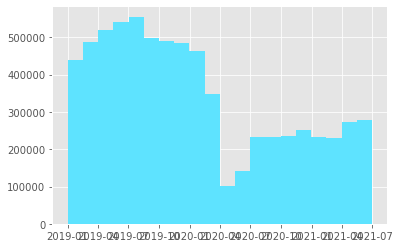

In [162]:
plt.hist(missing['date_num'], bins = 20, color = "#5ee3ff")

In [20]:
date_sum=flight_data_filtered.groupby('date_num')['iso_country'].agg('count')

date_sum=flight_data_filtered.groupby('date_num')['iso_country'].agg('count')

<AxesSubplot:xlabel='date_num'>

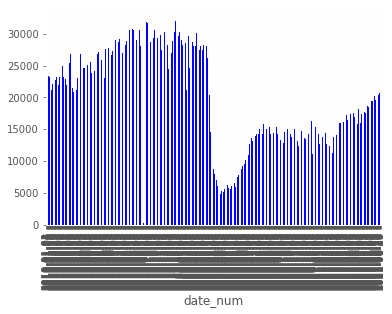

In [21]:

date_sum.plot.bar(color = 'b')

